In [1]:
%matplotlib inline
#!/usr/bin/env python3

In [ ]:
"""
Based on the non-map visualizations, I found out that Manhattan has the highest pedestrian activity, expecially duirng afternoon.

Manhattan Summer PM Pedestrian Activity Heatmap
"""

'\nManhattan Summer PM Pedestrian Activity Heatmap\nCreates a focused heatmap showing pedestrian activity in Manhattan during summer PM hours\n'

In [3]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import warnings

In [4]:
def extract_coordinates(ped_df):
    """Extract longitude and latitude from WKT format."""
    ped_df["Longitude"] = (
        ped_df["the_geom"].str.extract(r"POINT \(([-\d.]+)")[0].astype(float)
    )
    ped_df["Latitude"] = ped_df["the_geom"].str.extract(r"([-\d.]+)\)")[0].astype(float)
    return ped_df

In [5]:
def create_pedestrian_gdf(ped_df):
    """Create GeoDataFrame for pedestrian data."""
    ped_geometry = [Point(xy) for xy in zip(ped_df["Longitude"], ped_df["Latitude"])]
    ped_gdf = gpd.GeoDataFrame(ped_df, geometry=ped_geometry, crs="EPSG:4326")
    return ped_gdf

In [6]:
def load_manhattan_bounds():
    # Load MapPLUTO and get Manhattan bounds.
    pluto_gdf = gpd.read_file(
        "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/nyc_mappluto_25v2_shp"
    )
    manhattan_pluto = pluto_gdf[pluto_gdf["Borough"] == "MN"].copy()
    manhattan_pluto_wgs84 = manhattan_pluto.to_crs("EPSG:4326")
    manhattan_bounds = manhattan_pluto_wgs84.total_bounds
    return manhattan_pluto_wgs84, manhattan_bounds

In [7]:
def filter_manhattan_data(ped_gdf, manhattan_bounds):
    # Filter pedestrian data to Manhattan bounds.
    manhattan_ped = ped_gdf[
        (ped_gdf["Longitude"] >= manhattan_bounds[0])
        & (ped_gdf["Longitude"] <= manhattan_bounds[2])
        & (ped_gdf["Latitude"] >= manhattan_bounds[1])
        & (ped_gdf["Latitude"] <= manhattan_bounds[3])
    ].copy()
    return manhattan_ped

In [8]:
def find_summer_pm_columns(manhattan_ped):
    # Find summer PM data columns.
    all_columns = manhattan_ped.columns.tolist()
    summer_pm_columns = []

    # Look for summer PM data
    for col in all_columns:
        col_lower = col.lower()
        if any(
            month in col_lower for month in ["june", "july", "august", "summer"]
        ) and any(
            pm_indicator in col_lower
            for pm_indicator in ["pm", "afternoon", "evening", "late"]
        ):
            summer_pm_columns.append(col)

    # If no specific summer PM columns found, use PM-related columns
    if not summer_pm_columns:
        pm_columns = [
            col
            for col in all_columns
            if "pm" in col.lower()
            or "afternoon" in col.lower()
            or "evening" in col.lower()
        ]
        summer_pm_columns = pm_columns

    return summer_pm_columns


def calculate_summer_pm_counts(manhattan_ped, summer_pm_columns):
    # Calculate summer PM pedestrian counts.
    if summer_pm_columns:
        numeric_pm_columns = []
        for col in summer_pm_columns:
            try:
                pd.to_numeric(manhattan_ped[col], errors="coerce")
                numeric_pm_columns.append(col)
            except:
                continue

        if numeric_pm_columns:
            manhattan_ped["summer_pm_count"] = manhattan_ped[numeric_pm_columns].mean(
                axis=1
            )
        else:
            manhattan_ped = create_simulated_data(manhattan_ped)
    else:
        manhattan_ped = create_simulated_data(manhattan_ped)

    return manhattan_ped


def create_simulated_data(manhattan_ped):
    # Create simulated summer PM data when real data is not available.
    all_columns = manhattan_ped.columns.tolist()
    count_columns = [
        col
        for col in all_columns
        if "count" in col.lower() and col != "pedestrian_count"
    ]
    if count_columns:
        base_counts = manhattan_ped[count_columns].mean(axis=1)
        manhattan_ped["summer_pm_count"] = base_counts * 1.2 * 1.5
    else:
        manhattan_ped["summer_pm_count"] = 0
    return manhattan_ped

In [9]:
def setup_plot():
    # Setup the plot with 16:9 vertical layout.
    fig, ax = plt.subplots(1, 1, figsize=(9, 16))
    plt.subplots_adjust(left=0.10, right=0.90, top=0.95, bottom=0.05)

    # Remove axis labels and ticks
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xticks([])
    ax.set_yticks([])

    return fig, ax


def plot_manhattan_base(ax, manhattan_pluto_wgs84):
    # Plot Manhattan base map.
    manhattan_pluto_wgs84.plot(
        ax=ax,
        color="lightgray",
        alpha=0.3,
        edgecolor="none",  # Remove border
        linewidth=0,
    )

In [10]:
def plot_heatmap(ax, active_locations, fig):
    # Plot the heatmap with colorbar adjustments.
    if len(active_locations) == 0:
        ax.text(
            0.5,
            0.5,
            "No summer PM pedestrian data available",
            ha="center",
            va="center",
            transform=ax.transAxes,
            fontsize=14,
        )
        return

    # Create scatter plot
    plot = active_locations.plot(
        column="summer_pm_count",
        ax=ax,
        cmap="YlOrRd",
        markersize=150,
        alpha=0.9,
        legend=True,
        legend_kwds={
            "label": "Summer PM Pedestrian Count",
            "orientation": "vertical",
            "shrink": 0.6,  # Smaller colorbar
            "aspect": 20,  # Thinner colorbar
            "location": "right",
        },
    )

    # Adjust colorbar and map positions
    adjust_layout(fig, ax)

    # Move colorbar label to the right side
    for cax in fig.axes:
        if cax != ax:
            cax.set_ylabel("Summer PM Pedestrian Count", rotation=270, va="bottom")

    # Add title
    ax.set_title(
        "Manhattan Summer PM Pedestrian Activity",
        fontsize=18,
        fontweight="bold",
        pad=20,
    )

    # Add statistics box
    add_statistics_box(ax, active_locations)

In [11]:
def adjust_layout(fig, ax):
    # Adjust colorbar and map positions.
    # Move the colorbar to the right
    fig.canvas.draw()
    for cax in fig.axes:
        if cax != ax:
            pos = cax.get_position()
            cax.set_position(
                (
                    pos.x0 + 10 / fig.get_figwidth() / fig.dpi,
                    pos.y0,
                    pos.width,
                    pos.height,
                )
            )

    # Move the map to the left
    pos = ax.get_position()
    ax.set_position(
        (pos.x0 - 5 / fig.get_figwidth() / fig.dpi, pos.y0, pos.width, pos.height)
    )


def add_statistics_box(ax, active_locations):
    # Add statistics box to the plot.
    avg_count = active_locations["summer_pm_count"].mean()
    max_count = active_locations["summer_pm_count"].max()

    stats_text = f"""Statistics:
• Active Locations: {len(active_locations)}
• Average Count: {avg_count:,.0f}
• Maximum Count: {max_count:,.0f}"""

    ax.text(
        0.02,
        0.98,
        stats_text,
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment="top",
        bbox=dict(
            boxstyle="round,pad=0.5",
            facecolor="white",
            alpha=0.9,
            edgecolor="gray",
            linewidth=0.5,
        ),
    )

In [12]:
def save_plot(fig, filename="manhattan_summer_pm_heatmap.png"):
    # Save the plot.
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    # plt.close()  # <--- This line is now commented out

In [13]:
def print_summary(active_locations):
    # Print summary statistics.
    if len(active_locations) > 0:
        print(f"\n📊 Summary:")
        print(f"   Active locations: {len(active_locations)}")
        print(f"   Average count: {active_locations['summer_pm_count'].mean():.0f}")
        print(f"   Max count: {active_locations['summer_pm_count'].max():.0f}")

🔥 Creating Manhattan Summer PM Pedestrian Activity Heatmap...
   📍 Manhattan pedestrian locations: 68
   🕐 Found 1 summer PM columns: ['June24_PM']
   ✅ Manhattan Summer PM Pedestrian Activity Heatmap saved!

📊 Summary:
   Active locations: 66
   Average count: 5532
   Max count: 22089


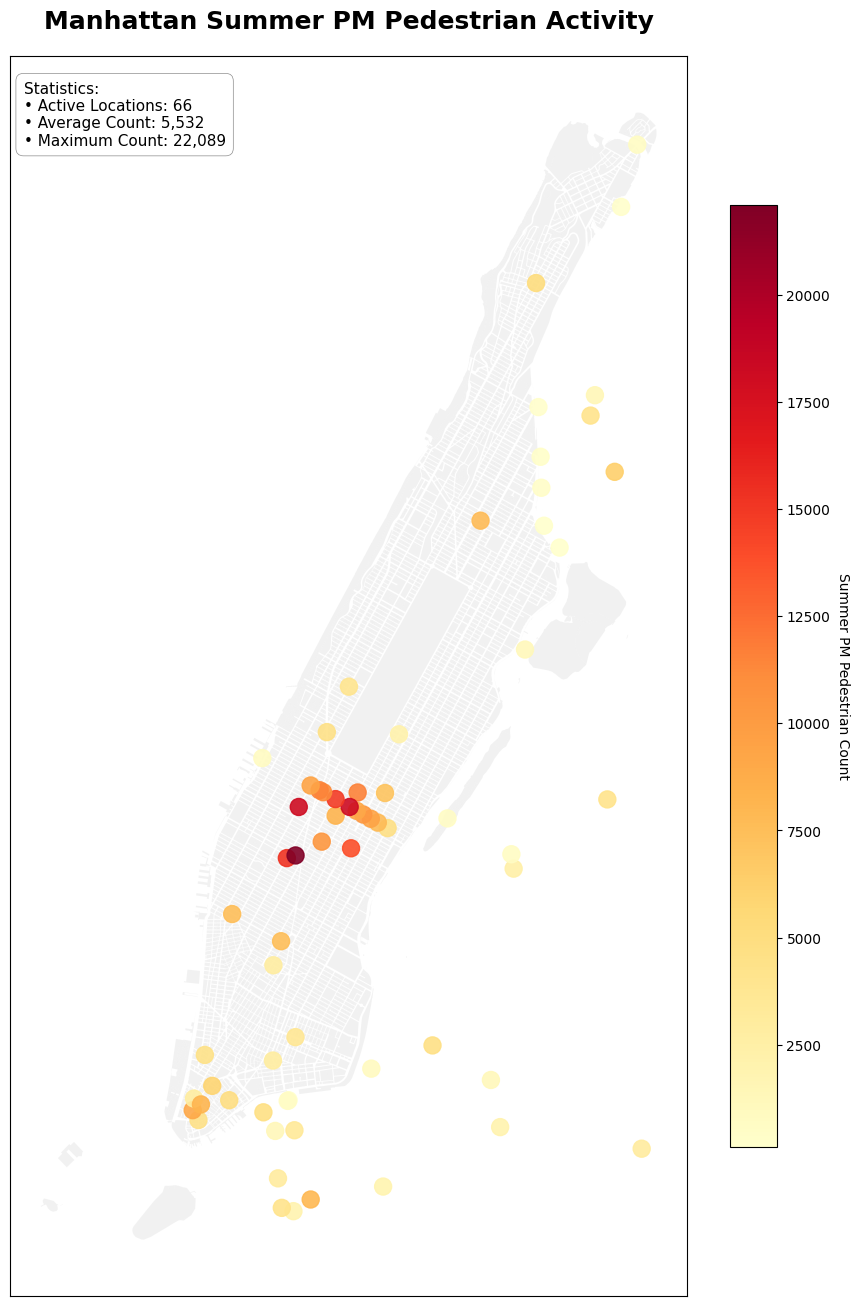

In [14]:
def create_manhattan_summer_pm_heatmap(ped_df=None, save_figure=True):
    """
    Create Manhattan summer PM pedestrian activity heatmap.

    Parameters:
    -----------
    ped_df : pandas.DataFrame, optional
        Pedestrian data DataFrame. If None, will try to load from default location.
    save_figure : bool, default True
        Whether to save the plot to file.

    Returns:
    --------
    tuple : (fig, ax, manhattan_ped, active_locations)
        Figure, axis, processed data, and active locations for further use.
    """
    print("🔥 Creating Manhattan Summer PM Pedestrian Activity Heatmap...")

    # Load data if not provided
    if ped_df is None:
        ped_df = pd.read_csv(
            "/Users/sunni/Desktop/GitHub/CDP-Mapping-Systems/Data/Bi-Annual_Pedestrian_Counts_20250709.csv"
        )

    # Process data
    ped_df = extract_coordinates(ped_df)
    ped_gdf = create_pedestrian_gdf(ped_df)
    manhattan_pluto_wgs84, manhattan_bounds = load_manhattan_bounds()
    manhattan_ped = filter_manhattan_data(ped_gdf, manhattan_bounds)

    print(f"   📍 Manhattan pedestrian locations: {len(manhattan_ped)}")

    # ✅ Find summer PM columns before calculating
    summer_pm_columns = find_summer_pm_columns(manhattan_ped)
    print(
        f"   🕐 Found {len(summer_pm_columns)} summer PM columns: {summer_pm_columns}"
    )
    manhattan_ped = calculate_summer_pm_counts(manhattan_ped, summer_pm_columns)

    # Create visualization
    fig, ax = setup_plot()
    plot_manhattan_base(ax, manhattan_pluto_wgs84)

    # Filter and plot active locations
    active_locations = manhattan_ped[manhattan_ped["summer_pm_count"] > 0].copy()
    plot_heatmap(ax, active_locations, fig)

    # Save and print summary
    if save_figure:
        save_plot(fig)
        print("   ✅ Manhattan Summer PM Pedestrian Activity Heatmap saved!")

    print_summary(active_locations)

    # Show the plot
    plt.show()

    return fig, ax, manhattan_ped, active_locations


# ✅ When running as a script
if __name__ == "__main__":
    create_manhattan_summer_pm_heatmap()

In [ ]:
@mariogiampieri